In [126]:
%matplotlib notebook

import tensorflow as tf
import numpy as np
import math

import matplotlib
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import matplotlib.pyplot as plt

In [127]:
# let's model y = 5 + x1*x2
def blackboxFn(X1, X2):
    return 6-X1*X2+X1**2+X2**2

X1 = np.linspace(-16, 16, 10)
X2 = np.linspace(-16, 16, 10)
X1, X2 = np.meshgrid(X1, X2)
Y = blackboxFn(X1, X2)

N = 100
D = 2
X1_total = 2*16*(np.random.rand(N)-0.5)
X2_total = 2*16*(np.random.rand(N)-0.5)
y_total = blackboxFn(X1_total, X2_total)

# 60% training, 20% cross-validation set and 20% test set
start_index = 0
training_N = int(N*0.6)
X_train = np.zeros((training_N,D))
y_train = np.zeros((training_N,1))
X_train[:,0] = X1_total[start_index:training_N]
X_train[:,1] = X2_total[start_index:training_N]
y_train = y_total[start_index:training_N].reshape(training_N, 1)

start_index += training_N
cv_N = int(N*0.2)
X_val = np.zeros((cv_N,D))
y_val = np.zeros((cv_N,1))
X_val[:,0] = X1_total[start_index:start_index+cv_N]
X_val[:,1] = X2_total[start_index:start_index+cv_N]
y_val = y_total[start_index:start_index+cv_N].reshape(cv_N, 1)

start_index += cv_N
test_N = int(N*0.2)
X_test = np.zeros((test_N,D))
y_test = np.zeros((test_N,1))
X_test[:,0] = X1_total[start_index:start_index+test_N]
X_test[:,1] = X2_total[start_index:start_index+test_N]
y_test = (y_total[start_index:start_index+test_N]).reshape(test_N, 1)

<IPython.core.display.Javascript object>


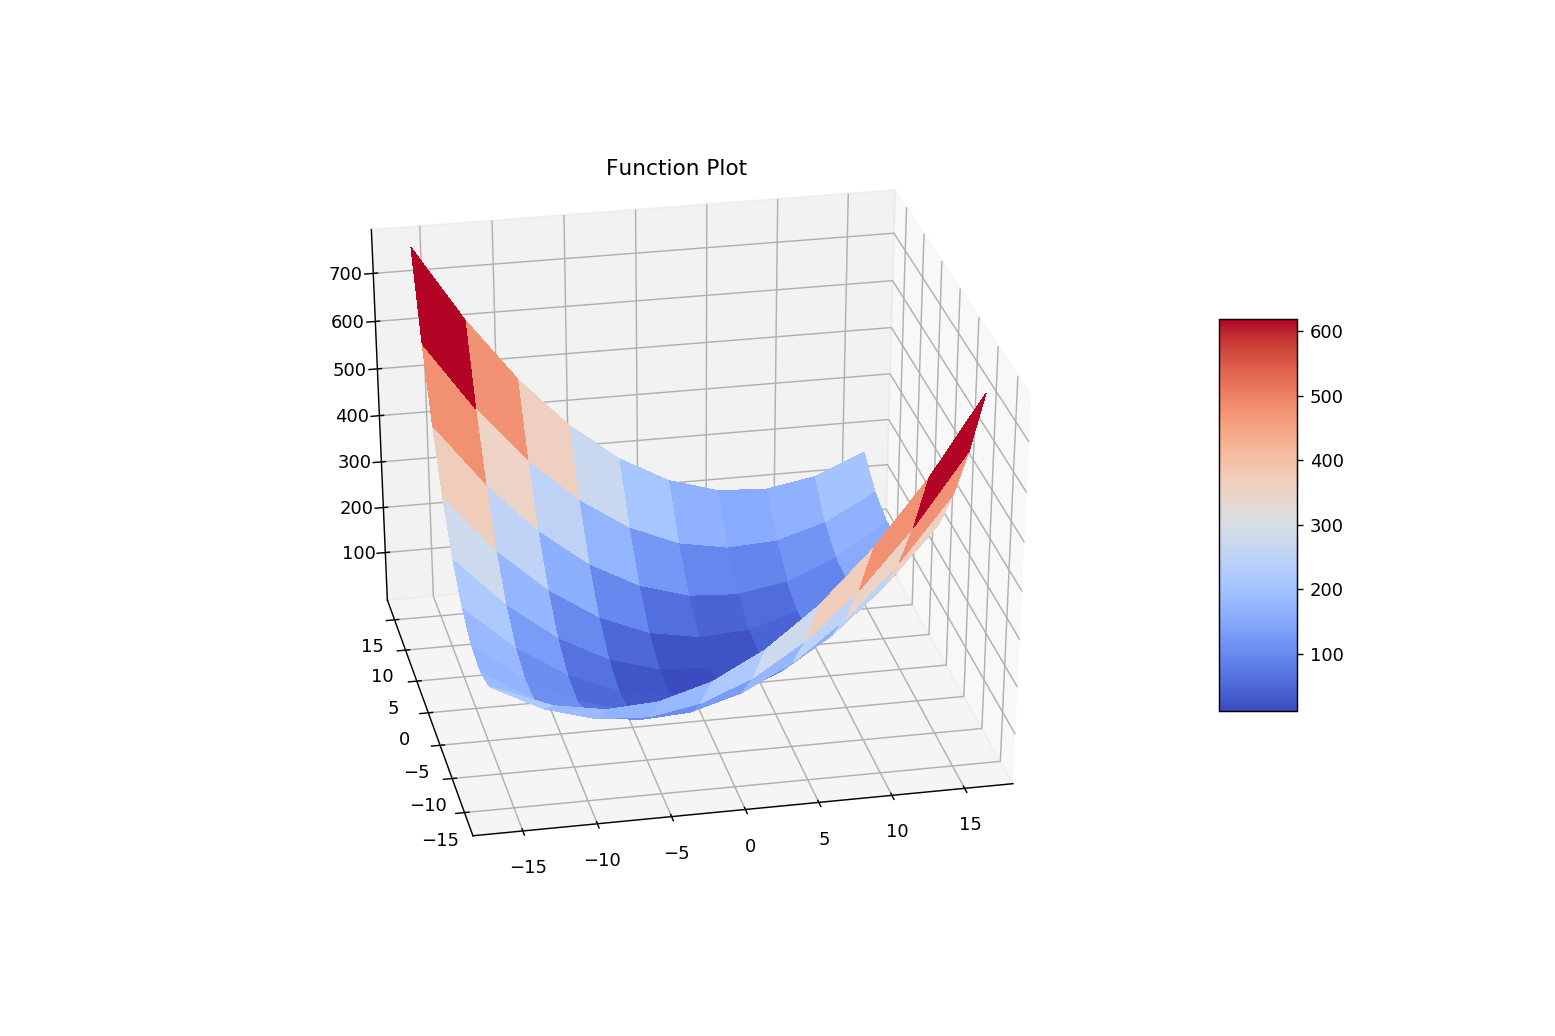

In [128]:
def show_3D_plot(X1, X2, Y, name, plot="surface"):
    fig = plt.figure(figsize=(12,8))
    ax = fig.add_subplot(111, projection='3d')
    surf = None
    if plot == "scatter":
        surf = ax.scatter(X1, X2, Y)
    else:
        surf = ax.plot_surface(X1, X2, Y, rstride=1, cstride=1, cmap=cm.coolwarm, linewidth=0, antialiased=False)
        fig.colorbar(surf, shrink=0.5, aspect=5)
    plt.title(name)
    plt.ion()
    plt.show()
    plt.savefig(name+'.png')

show_3D_plot(X1, X2, Y, "Function Plot")

<IPython.core.display.Javascript object>


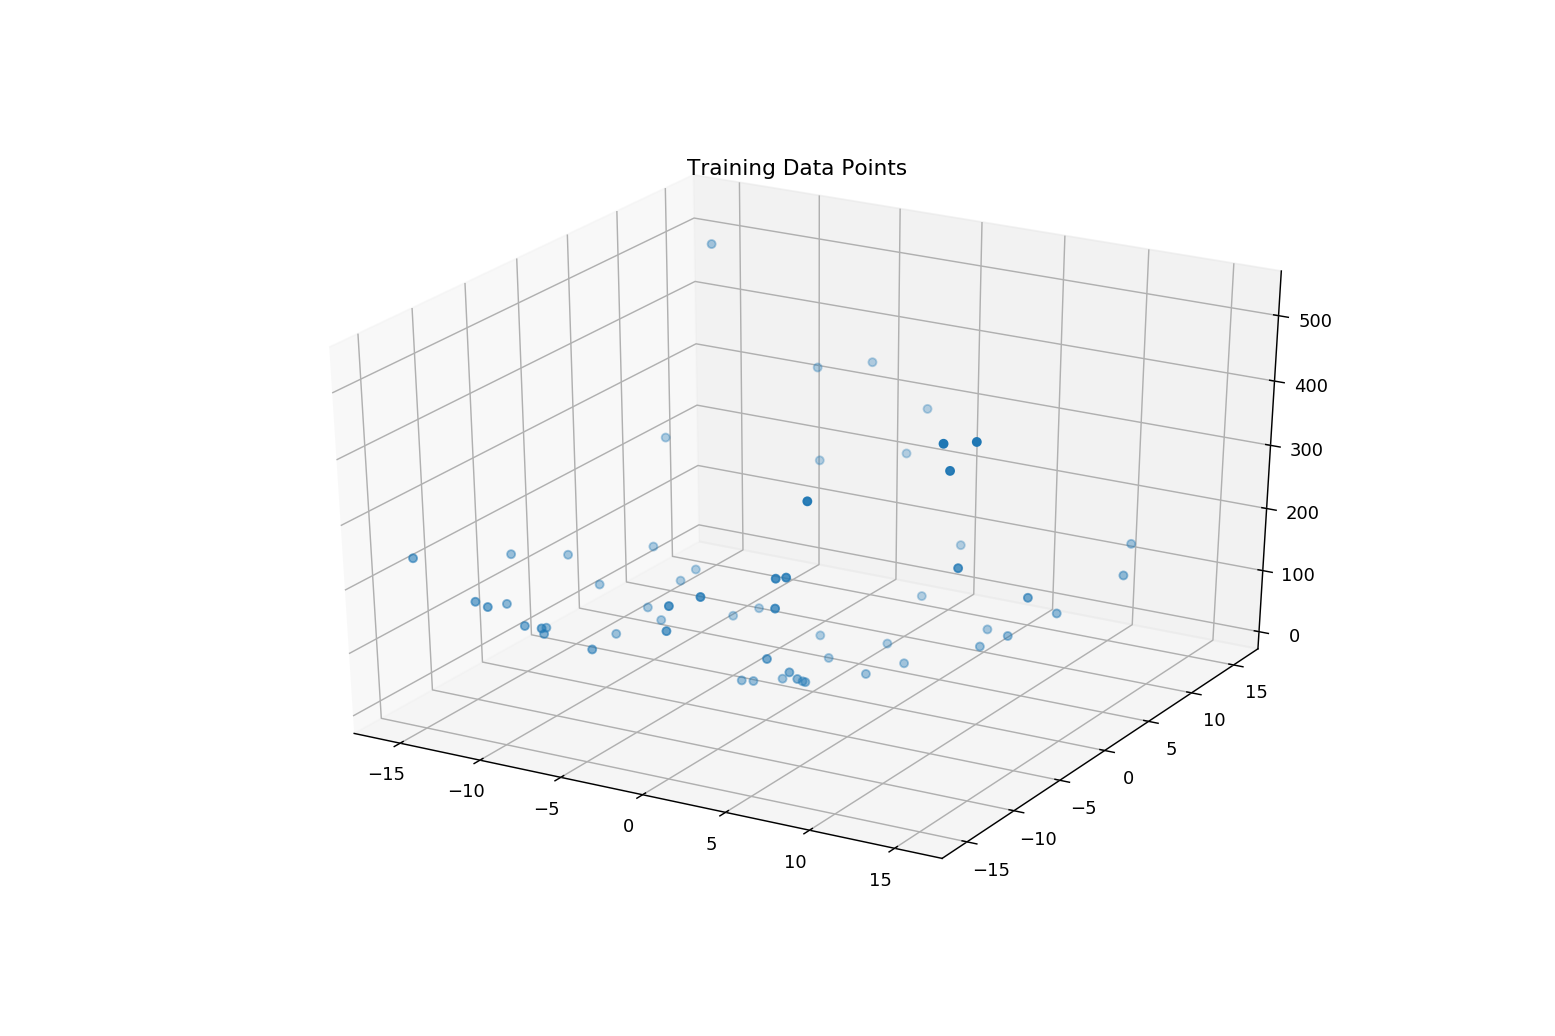

In [129]:
show_3D_plot(X_train[:,0], X_train[:,1], y_train, "Training Data Points", "scatter")

In [148]:
def weight_variable(shape, name):
    initial = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(initial, name=name)

def bias_variable(shape, name):
    initial = tf.constant(0.1, shape=shape)
    return tf.Variable(initial, name=name)

In [217]:
# clear old variables
tf.reset_default_graph()

X = tf.placeholder(tf.float32, [None, D])
y = tf.placeholder(tf.float32, [None, 1])
is_training = tf.placeholder(tf.bool)

# Number of hidden neurons
H1 = 16
H2 = 9
def deeper_model(X):
    W1 = weight_variable([D,H1], "h1_weights")
    b1 = bias_variable([H1], "h1_biases")
    W2 = weight_variable([H1,H2], "h2_weights")
    b2 = bias_variable([H2], "h2_biases")
    W3 = weight_variable([H2,1], "out_weights")
    b3 = bias_variable([1], "out_biases")
    h1_out = tf.nn.tanh(tf.matmul(X, W1) + b1)
    h2_out = tf.nn.sigmoid(tf.matmul(h1_out, W2) + b2)
    y_out = tf.matmul(h2_out, W3) + b3
    return y_out

y_out = deeper_model(X)

regularization_strength = 0.001
trainable_vars   = tf.trainable_variables()
lossL2 = tf.add_n([ tf.nn.l2_loss(v) for v in trainable_vars if 'bias' not in v.name ])

ms_loss = tf.losses.mean_squared_error(labels=y, predictions=y_out)
mean_loss = tf.reduce_mean(ms_loss) + lossL2*regularization_strength

In [252]:
def run_model(session, predict, loss_val, Xd, yd,
              epochs=1, batch_size=64, print_every=100,
              training=None, plot=False):
    # shuffle indicies
    train_indicies = np.arange(Xd.shape[0])
    np.random.shuffle(train_indicies)

    training_now = training is not None
    # setting up variables we want to compute (and optimizing)
    # if we have a training function, add that to things we compute
    
    squared_loss = tf.squared_difference(predict, y)
    mean_squared_loss = tf.reduce_mean(squared_loss)
    variables = [mean_loss, squared_loss, mean_squared_loss]
    if training_now:
        variables[-1] = training
        
    training_epoch_loss = []
    training_epoch_ms_loss = []
    validation_epoch_loss = []
    validation_epoch_ms_loss = []
    total_loss = 0
    total_mean_squared_loss = 0
    for e in range(epochs):
        # keep track of losses and ms losses
        losses = []
        squared_losses = []
        
        # make sure we iterate over the dataset once
        for i in range(int(math.ceil(Xd.shape[0]/batch_size))):
            # generate indicies for the batch
            start_idx = (i*batch_size)%Xd.shape[0]
            idx = train_indicies[start_idx:start_idx+batch_size]
            
            # create a feed dictionary for this batch
            feed_dict = {X: Xd[idx,:],
                         y: yd[idx],
                         is_training: training_now }
            # get batch size
            actual_batch_size = yd[idx].shape[0]
            
            # have tensorflow compute loss and correct predictions
            # and (if given) perform a training step
            loss, squared_loss, _ = session.run(variables,feed_dict=feed_dict)
            # aggregate performance stats
            losses.append(loss*actual_batch_size)
            squared_losses.append(np.sum(squared_loss))
        
        total_loss = np.sum(losses)/Xd.shape[0]
        total_mean_squared_loss = np.sum(squared_loss)/Xd.shape[0]
        
        # print every now and then
        if print_every and ((e % print_every) == 0 or e == epochs-1):
            print("Epoch {2}, Overall loss = {0:.3g} and MS loss of {1:.3g}"\
                  .format(total_loss,total_mean_squared_loss,e+1))
        
        if training_now:
            training_epoch_loss.append(total_loss)
            training_epoch_ms_loss.append(total_mean_squared_loss)
            cv_loss, cv_ms_loss = run_model(session,predict,loss_val,X_val,y_val,1,batch_size,None)
            validation_epoch_loss.append(cv_loss)
            validation_epoch_ms_loss.append(cv_ms_loss)
        
    if plot:
        plt.plot(training_epoch_loss)
        plt.plot(validation_epoch_loss)
        plt.plot(training_epoch_ms_loss)
        plt.plot(validation_epoch_ms_loss)
        plt.grid(True)
        plt.title('Training vs Cross-Validation')
        plt.xlabel('epoch number')
        plt.ylabel('loss')
        plt.legend(['Training Loss','Cross-Validation Loss', 'Training MS Loss', 'Cross-Validation MS Loss'], loc='upper left')
        plt.show()
    
    return total_loss, total_mean_squared_loss

Training
Epoch 1, Overall loss = 4.63e+04 and MS loss of 1.17e+04
Epoch 101, Overall loss = 3.43e+04 and MS loss of 9.14e+03
Epoch 201, Overall loss = 2.7e+04 and MS loss of 7.55e+03
Epoch 301, Overall loss = 2.26e+04 and MS loss of 6.57e+03
Epoch 401, Overall loss = 2.02e+04 and MS loss of 6e+03
Epoch 501, Overall loss = 1.9e+04 and MS loss of 5.7e+03
Epoch 601, Overall loss = 1.85e+04 and MS loss of 5.56e+03
Epoch 701, Overall loss = 1.83e+04 and MS loss of 5.5e+03
Epoch 801, Overall loss = 1.83e+04 and MS loss of 5.48e+03
Epoch 901, Overall loss = 1.83e+04 and MS loss of 5.47e+03
Epoch 1000, Overall loss = 1.83e+04 and MS loss of 5.47e+03


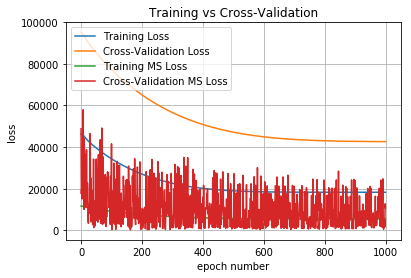

Test
Epoch 1, Overall loss = 1.34e+04 and MS loss of 1.5e+03


In [253]:
%matplotlib inline
train_step = tf.train.AdamOptimizer(0.01).minimize(mean_loss)
sess = tf.Session()
with tf.device("/cpu:0"): #"/cpu:0" or "/gpu:0" 
    sess.run(tf.global_variables_initializer())
    print('Training')
    run_model(sess,y_out,mean_loss,X_train,y_train,1000,16,100,train_step, plot=True)
    print('Test')
    run_model(sess,y_out,mean_loss,X_test,y_test,1,16, plot=False)